In [192]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import  seaborn as sns
sns.set_style("darkgrid")

from Utils import *
from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

In [193]:
# (tr_x,tr_y), (vl_x,vl_y), (ts_x,ts_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv")
(tr_x,tr_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv",unique=True)

In [194]:
# m = ENeuralN(10,100,0,sigmoid)

In [195]:
# m.resevoir(tr_x)

In [197]:
# MSE(w_star[0].T@m.resevoir(tr_x), tr_y)

# JUST AN EXAMPLE

In [277]:
resevoir = np.random.uniform(0, 1,(150,10))

## Optimal solution

In [278]:
tr_x.shape, resevoir.shape

((10, 1182), (150, 10))

In [279]:
(resevoir@tr_x).shape, tr_y.shape

((150, 1182), (2, 1182))

In [281]:
(np.random.random((2,150))@(resevoir@tr_x)).shape

(2, 1182)

In [282]:
w_star,_,_,_ = np.linalg.lstsq((resevoir@tr_x).T, tr_y.T)

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21172\1676766576.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_star,_,_,_ = np.linalg.lstsq((resevoir@tr_x).T, tr_y.T)


In [283]:
w_star.T.shape,(w_star.T@(resevoir@tr_x)).shape

((2, 150), (2, 1182))

In [284]:
MSE(w_star.T@(resevoir@tr_x),tr_y)

169.56424665960026

In [256]:
model = fit_cholesky(tr_x,tr_y, hidden=100,lambda_=1e-01, activation=sigmoid, resevoir=resevoir)

In [257]:
get_results(model,tr_x,tr_y)

1.6347480770431768

In [212]:
instance1 = fit_sgd(tr_x, tr_y, hidden=200, lambda_=0.001, activation=sigmoid,
                    max_inters=150, eps=0.0001, lr=0, beta=0, resevoir=resevoir)

instance2 = fit_sgd(tr_x, tr_y, hidden=200, lambda_=0.001, activation=sigmoid,
                    max_inters=150, eps=0.0001, lr=0, beta=0.5, resevoir=resevoir)  

instance3 = fit_fista(tr_x, tr_y, hidden=200, lambda_=0.001, activation=sigmoid,
                      max_inters=150, eps=0.0001, resevoir=resevoir)

In [213]:
print(f"MSE at the last iteration:\nSGD {instance1[2]}\nSGD-M {instance2[2]}\nFISTA {instance3[2]}")

MSE at the last iteration:
SGD 2.8127
SGD-M 2.4047
FISTA 2.3754


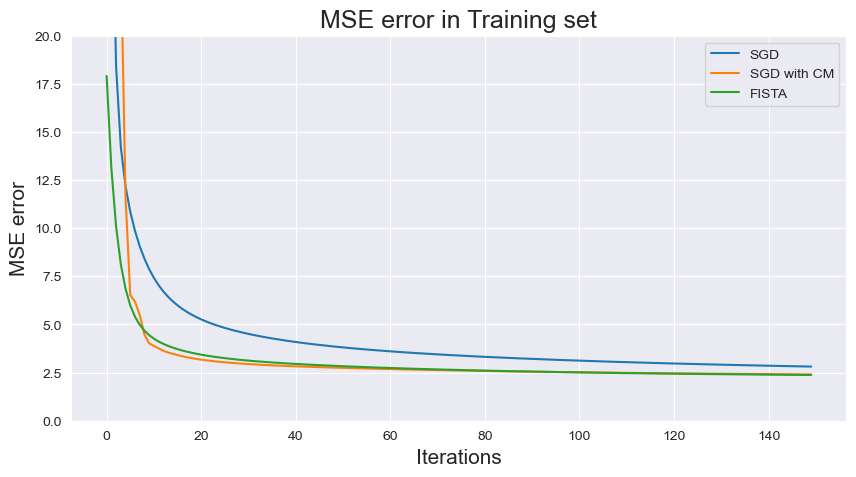

In [214]:
f, axs = plt.subplots(figsize=(10,5))
sns.lineplot(data=instance1[1], x=instance1[1].index, y="MSE_error", ax=axs, label="SGD")
sns.lineplot(data=instance2[1], x=instance2[1].index, y="MSE_error", ax=axs, label="SGD with CM")
sns.lineplot(data=instance3[1], x=instance3[1].index, y="MSE_error", ax=axs, label="FISTA")
axs.set_ylim([0,20])
axs.set_title("MSE error in Training set",fontsize=18)
axs.set_ylabel("MSE error",fontsize=15)
axs.set_xlabel("Iterations",fontsize=15)
axs.legend()
plt.show()

# GRIDSEARCH CHOLESKY

In [204]:
parameter_cholesky = dict(
    hidden=[*range(10,500,10)],
    lambda_ =  [0.001,0.0005],
    activation = [sigmoid, ReLU, tanH]
)

In [205]:
# grid_search_cholesky(configs=parameter_cholesky, train=(tr_x,tr_y), valid=(vl_x,vl_y))

# GRIDSEARCH FISTA

In [206]:
parameter_fista = dict(
    hidden=[*range(10,500,15)],
    lambda_ =  [0.0005],
    activation = [sigmoid],
    max_inters=[1000, 5000],
    eps=[0]
)

In [207]:
# grid_search_iterative(configs=parameter_fista, train=(tr_x,tr_y), valid=(vl_x,vl_y), optimizer="FISTA")

# GRIDSEARCH SDG

In [208]:
parameter_sgd = dict(
    hidden=[*range(10,500,15)],
    lambda_ =  [0.0005],
    activation = [sigmoid],
    max_inters=[1000],
    eps=[0],
    lr=[0],
    beta=[0]
)

In [209]:
# grid_search_iterative(configs=parameter_sgd, train=(tr_x,tr_y), valid=(vl_x,vl_y), optimizer="SGD")

# GRIDSEARCH SGD with CLASSICAL MOMENTUM

In [210]:
parameter_sgd = dict(
    hidden=[*range(10,500,15)],
    lambda_ =  [0.0005],
    activation = [sigmoid],
    max_inters=[1000],
    eps=[0],
    lr=[0],
    beta=[0.99]
)

In [211]:
# grid_search_iterative(configs=parameter_sgd, train=(tr_x,tr_y), valid=(vl_x,vl_y), optimizer="SGD")